# Tutorial on adding custom constraint to RBA-problem

### In this tutorial we show how to extend an RBA-problem with a user-defined constraint, imposing a specific relationship between model-variables and analyse its effect on predicted states.

Metabolic regimes of respiration and fermentation are characterised by specific ratios between metabolised glucose and oxygen. With increasing use of fermentation pathways the ratio of metabolised glucose per oxygen increases. In order to assess the effect of several imposed ratios on phenotype, different ratios are imposed and the phenotypes at different glucose concentrations in the medium are predicted.

#### The main objective of this tutorial is not to ask or answer a biological question. Instead we want to show and exemplify how to manipulate the RBA-problem with different built-in methods of rbatools.

In [1]:
import matplotlib.pyplot as plt
import numpy

from rbatools.rba_session import SessionRBA
from rbatools.rba_problem_matrix import ProblemMatrix
from sample_models import sample_model_loader
from scipy.sparse import coo_matrix

## Load model

In [2]:
#model_filename = '../../../Bacterial-RBA-models/Bacillus-subtilis-168-WT' #if you have cloned the Bacterial-RBA-models repo
model_filename = sample_model_loader.get_sample_model(model='Bacillus-subtilis-168-WT') #use included sample model

Simulation = SessionRBA(xml_dir=model_filename, lp_solver="swiglpk")# swiglpk or cplex


## Define functions for glucose screen and plotting

In [3]:
def run_glucose_screen(Simulation,glcs):
    Results_glc_screen = {"Mu":[],"M_glc":[],"M_o2":[],"M_ac":[]} # generate empty structure to store results of interest
    for glc_conc in glcs: # iterate through all generated glucose concentrations
        Simulation.set_medium({'M_glc':glc_conc}) #set glucose concnetration to respective value
        #determine growth-optimal state and maximum growth-rate:
        mumax = Simulation.find_max_growth_rate()
        if mumax!=0:
            J_ex = Simulation.return_exchange_fluxes() # obtain corresponding exchange-fluxes
            # write growth-rate and exchanges for glucose, oxygen and acetate to storing structure:
            for i in Results_glc_screen.keys():
                if i == "Mu":
                    Results_glc_screen["Mu"].append(mumax)
                else:
                    if i in J_ex.keys():
                        Results_glc_screen[i].append(J_ex[i])
                    else:
                        Results_glc_screen[i].append(0)
        else:
            for i in Results_glc_screen.keys():
                if i == "Mu":
                    Results_glc_screen["Mu"].append(numpy.nan)
                else:
                    Results_glc_screen[i].append(numpy.nan)

    return(Results_glc_screen)


In [4]:
def plot_glc_screen_results(glcs,Results_glc_screen):
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(111)
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=5, alpha=0.6, color="dimgray")
    ax.legend(["Monod curve"], loc="upper left", fontsize=12, frameon=False)
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=13, alpha=0.6, color="gainsboro")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=10, alpha=0.6, color="lightgray")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=7, alpha=0.6, color="silver")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=5, alpha=0.6, color="gray")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=2, alpha=0.6, color="dimgray")
    ax.plot(glcs, Results_glc_screen["Mu"], linewidth=1, alpha=0.6, color="black")
    ax2=ax.twinx()
    ax2.plot(glcs, [i for i in Results_glc_screen["M_ac"]], linewidth=4,
             color="mediumseagreen", alpha=0.9)
    ax2.plot(glcs, [-i for i in Results_glc_screen["M_o2"]], linewidth=4, 
             color="indianred", alpha=0.9, linestyle=(0, (1, 1)))
    ax2.plot(glcs, [-i for i in Results_glc_screen["M_glc"]], linewidth=4, 
             color="steelblue", alpha=0.9, linestyle=(0, (3, 1, 1, 1)))
    ax2.legend(["$Acetate$ excretion","$O_2$ uptake","$Glucose$ uptake"], 
               loc="lower right", fontsize=12, frameon=False)

    ax.set_title("Glucose dependent growth-rate and exchange fluxes", fontsize=15)
    ax.set_xlabel("Glucose concentration (mM)", fontsize=12)
    ax.tick_params(axis='y', labelcolor="dimgrey")
    ax2.tick_params(axis='y', labelcolor="black")
    ax.set_ylabel("Growth rate ($h^{-1}$)", color="dimgrey", fontsize=12)
    ax2.set_ylabel('Exchange fluxes ($\\frac{mmol}{h \\times g_{DW}}$)', 
                   color="black", fontsize=12)
    plt.tight_layout()
    plt.show()


In [5]:
def plot_o2_glc_uptake_ratio(glcs,Results_glc_screen):
    o2_glc_ratio_original=[Results_glc_screen["M_o2"][i]/Results_glc_screen["M_glc"][i] for i in range(len(glcs))]
    plt.scatter(glcs,o2_glc_ratio_original)
    plt.title("Ratio $O_2$ over Glucose uptake")
    plt.xlabel("Glucose concentration (mM)")
    plt.ylabel("$J^{ex}_{O2}$ / $J^{ex}_{GLC}$")
    plt.show()

## Define glucose concentrations to screen

In [6]:
glcs = [0.005+(i*0.005) for i in range(13)] # generate glucose concentration intervals


## Run initial glucose screen and plot ratio of uptaken oxygen over glucose

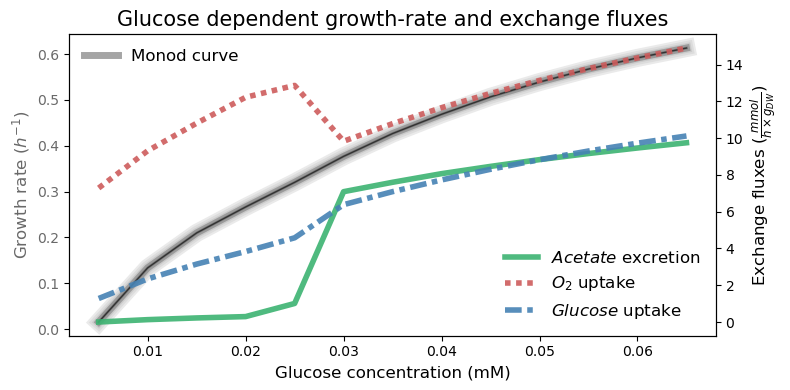

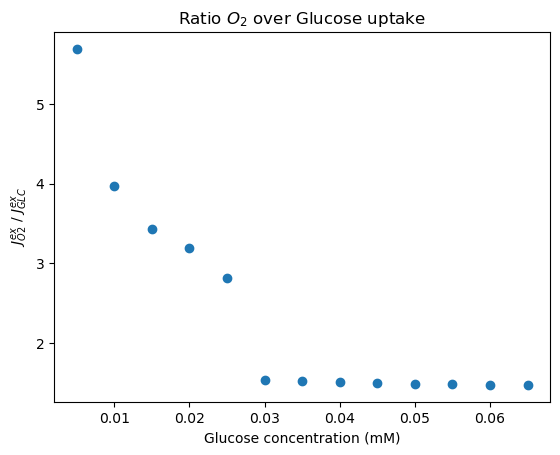

In [7]:
#Simulation.reload_model()
Results_glc_screen_original=run_glucose_screen(Simulation,glcs)

plot_glc_screen_results(glcs,Results_glc_screen_original)
plot_o2_glc_uptake_ratio(glcs,Results_glc_screen_original)

## Add constraint to RBA-problem, imposing pre-defined oxygen/glucose ratio

At first we have to define a linear problem, representing the constraints to add, as an rbatools.rba_problem_matrix.ProblemMatrix object. This object contains all necessary information to define a linear problem.

In [9]:
#Simulation.reload_model()
imposed_o2_glc_ratio=5

matrix_to_add=ProblemMatrix()
# defining constraint and variable IDs (J_o2='To2' & J_glc='TptsG'):
matrix_to_add.row_names=['o2_glc_ratio'] # ID of constraint to add
matrix_to_add.col_names=['To2','TptsG'] # Variable, associated with constraint (glucose- and oxygen transport-reactions)

# defining constraint: J_o2 / J_glc = imposed_o2_glc_ratio --> 'To2' - imposed_o2_glc_ratio * 'TptsG' = 0:
matrix_to_add.A=coo_matrix(numpy.array([[1,-imposed_o2_glc_ratio]])) # left-hand side of imposed constraint
matrix_to_add.b=numpy.array([0]) # right-hand side of imposed constraint
matrix_to_add.row_signs=['E'] # type of imposed constraint (equality)

# Since we do not want to change the objective-coeficients and variable-bounds, associated with 'To2' & 'TptsG',
# we take the values  from the original RBA-problem and impose them onto the matrix:
original_objective_coefficients=Simulation.Problem.get_objective(['To2','TptsG']) # get objective coefficients
original_lb_coefficients=Simulation.Problem.get_lb(['To2','TptsG']) # get variables' lower bounds
original_ub_coefficients=Simulation.Problem.get_ub(['To2','TptsG']) # get variables' upper bounds
# set the respective fields in matrix to obtained values
matrix_to_add.f=numpy.array([original_objective_coefficients['To2'],original_objective_coefficients['TptsG']])
matrix_to_add.LB=numpy.array([original_lb_coefficients['To2'],original_lb_coefficients['TptsG']])
matrix_to_add.UB=numpy.array([original_ub_coefficients['To2'],original_ub_coefficients['TptsG']])

# merge defined matrix with original RBA-problem (adding new constraint)
Simulation.Problem.LP.add_matrix(matrix=matrix_to_add)


In [11]:
print(matrix_to_add)

### Run glucose screen with imposed oxygen/glucose ratio

In [12]:
Results_glc_screen_ratio_5=run_glucose_screen(Simulation,glcs)

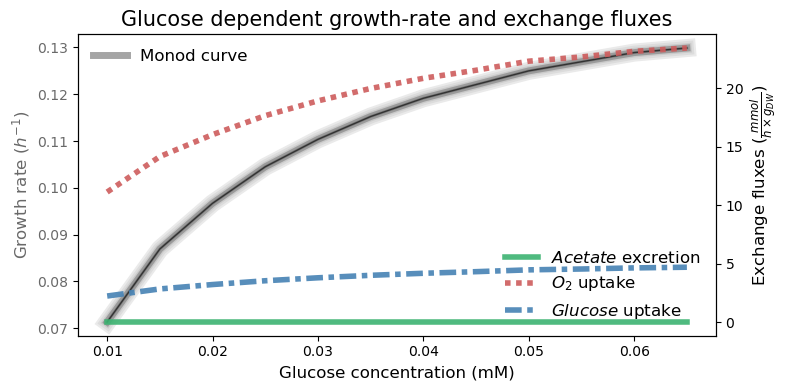

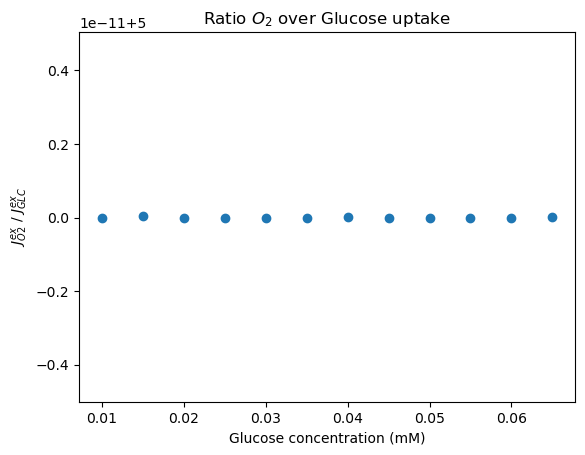

In [13]:
plot_glc_screen_results(glcs,Results_glc_screen_ratio_5)
plot_o2_glc_uptake_ratio(glcs,Results_glc_screen_ratio_5)

## Impose other ratios and run glucose screen

### Update constraint matrix with new matrix

Here we use one method to change the ratio-coefficient. The .update_matrix problem, updates problem coefficients of original problem with the ones defined in matrix.

In [14]:
#Simulation.reload_model()
imposed_o2_glc_ratio=2

matrix_to_add=ProblemMatrix()
matrix_to_add.row_names=['o2_glc_ratio']
matrix_to_add.col_names=['To2','TptsG']
matrix_to_add.A=coo_matrix(numpy.array([[1,-imposed_o2_glc_ratio]]))
matrix_to_add.b=numpy.array([0])
matrix_to_add.row_signs=['E']

original_objective_coefficients=Simulation.Problem.get_objective(['To2','TptsG'])
original_lb_coefficients=Simulation.Problem.get_lb(['To2','TptsG'])
original_ub_coefficients=Simulation.Problem.get_ub(['To2','TptsG'])
matrix_to_add.f=numpy.array([original_objective_coefficients['To2'],original_objective_coefficients['TptsG']])
matrix_to_add.LB=numpy.array([original_lb_coefficients['To2'],original_lb_coefficients['TptsG']])
matrix_to_add.UB=numpy.array([original_ub_coefficients['To2'],original_ub_coefficients['TptsG']])

Simulation.Problem.LP.update_matrix(matrix=matrix_to_add)


In [15]:
Results_glc_screen_ratio_2=run_glucose_screen(Simulation,glcs)

### Set individual Problem coefficients
Here we use another method to change the ratio-coefficient. The .set_problem_coefficients method, sets individual matrix (problem's left-hand side) coefficients to specified value.

In [16]:
# See old coefficient
Simulation.Problem.get_problem_coefficients([('o2_glc_ratio','TptsG')])

{('o2_glc_ratio', 'TptsG'): -2.0}

In [17]:
# Set coefficient to new value
Simulation.Problem.set_problem_coefficients({('o2_glc_ratio','TptsG'):-1})

In [18]:
# See new coefficient
Simulation.Problem.get_problem_coefficients([('o2_glc_ratio','TptsG')])

{('o2_glc_ratio', 'TptsG'): -1.0}

In [19]:
Results_glc_screen_ratio_1=run_glucose_screen(Simulation,glcs)

## Plot screen results of different oxygen/glucose ratios.

WT - no constraint on ratio (ratio able to change)


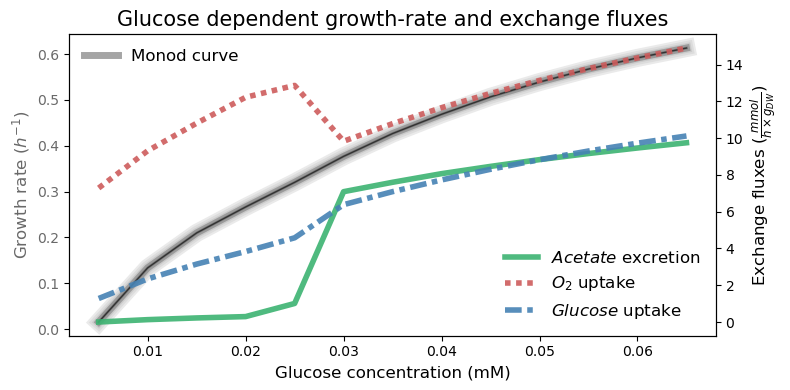

Imposed oxygen/glucose ratio of 5 (ratio of respiratory regime in WT)


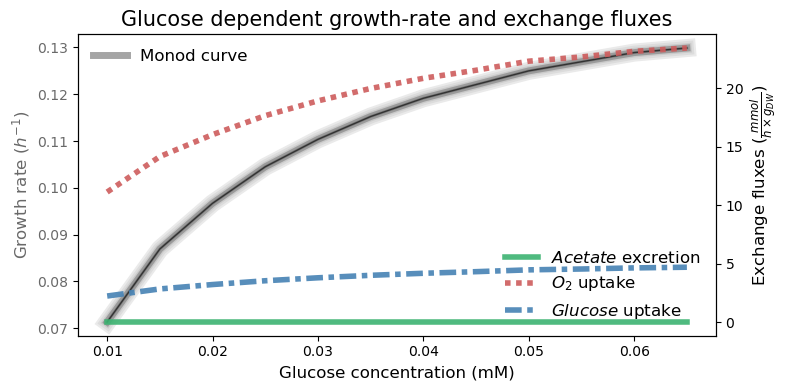

Imposed oxygen/glucose ratio of 2 (ratio at switch to fermentation in WT)


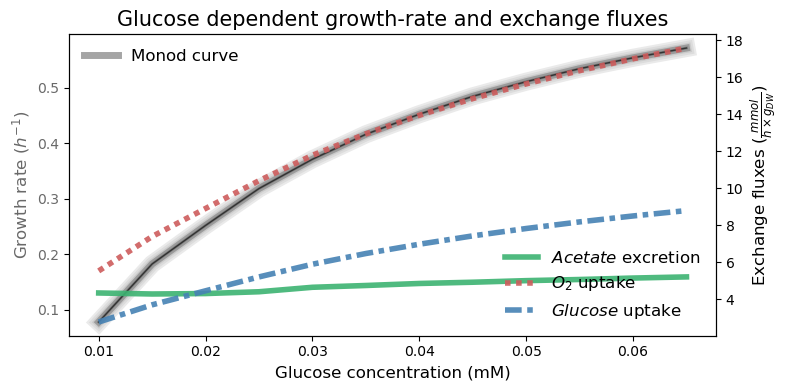

Imposed oxygen/glucose ratio of 1 (ratio of fermenting regime in WT)


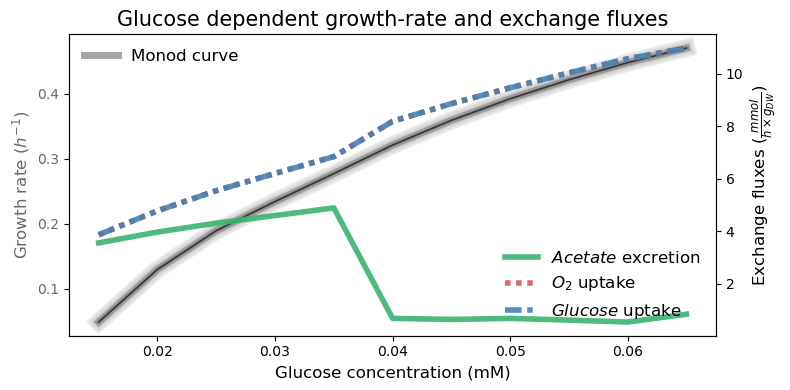

In [20]:
print("WT - no constraint on ratio (ratio able to change)")
plot_glc_screen_results(glcs,Results_glc_screen_original)
print("Imposed oxygen/glucose ratio of 5 (ratio of respiratory regime in WT)")
plot_glc_screen_results(glcs,Results_glc_screen_ratio_5)
print("Imposed oxygen/glucose ratio of 2 (ratio at switch to fermentation in WT)")
plot_glc_screen_results(glcs,Results_glc_screen_ratio_2)
print("Imposed oxygen/glucose ratio of 1 (ratio of fermenting regime in WT)")
plot_glc_screen_results(glcs,Results_glc_screen_ratio_1)